## 0. Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.gridspec as gs


pt.update_plot_defaults()


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train, shuffle=True, generator=data_generator)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:10000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

# Backprop network

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch accuracy = 94.3499984741211%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:490: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:207: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


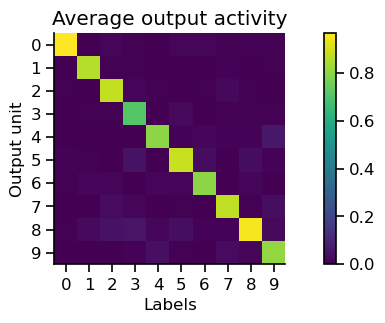

<Figure size 1000x300 with 0 Axes>

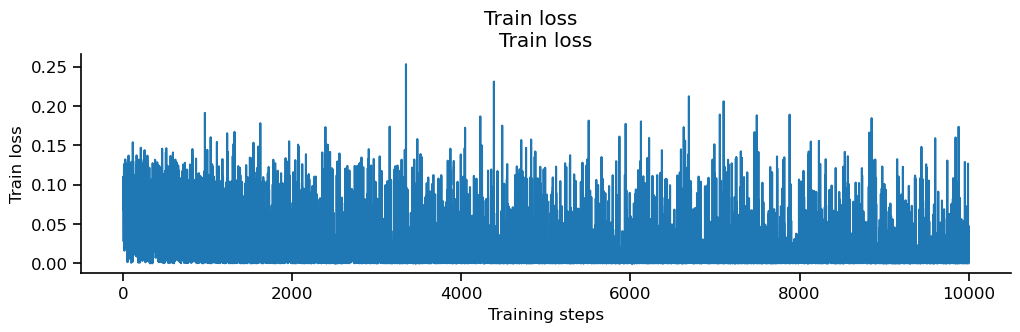

In [2]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_relu_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bp_network.train_and_validate(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,100),
                              store_history=False, 
                              store_weights=False, 
                              status_bar=True)

pt.plot_batch_accuracy(bp_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(bp_network)
plt.title('Train loss')
plt.show()

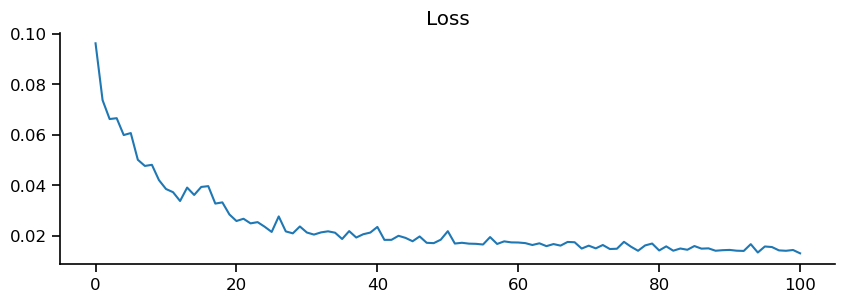

In [3]:
# pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=50)
# pt.plot_MNIST_examples(bp_network, test_dataloader)
plt.figure()
plt.plot(bp_network.val_loss_history)
plt.title('Loss')
plt.show()

In [4]:
bp_network

Network(
  (criterion): MSELoss()
  (module_dict): ModuleDict(
    (H1E_InputE): Projection(in_features=784, out_features=500, bias=False)
    (OutputE_H1E): Projection(in_features=500, out_features=10, bias=False)
  )
  (parameter_dict): ParameterDict(
      (H1E_bias): Parameter containing: [torch.FloatTensor of size 500]
      (OutputE_bias): Parameter containing: [torch.FloatTensor of size 10]
  )
)

  0%|          | 0/10000 [00:00<?, ?it/s]

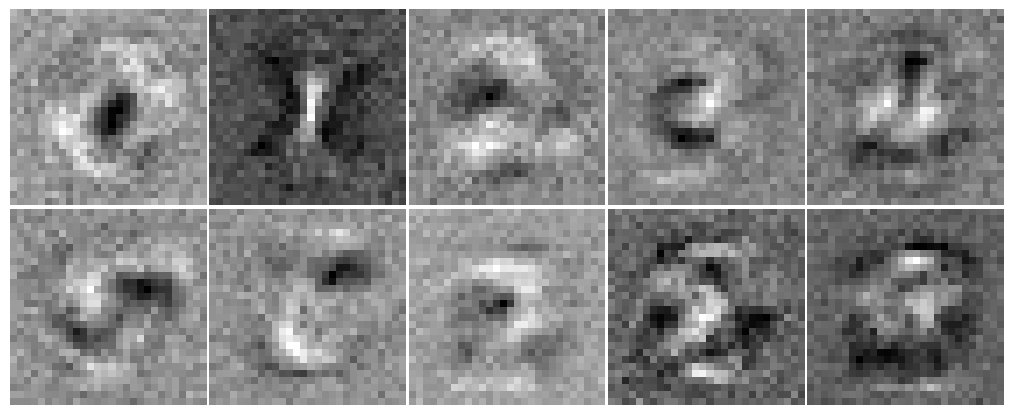

In [4]:
pt.plot_receptive_fields(bp_network.Output.E, test_dataloader)

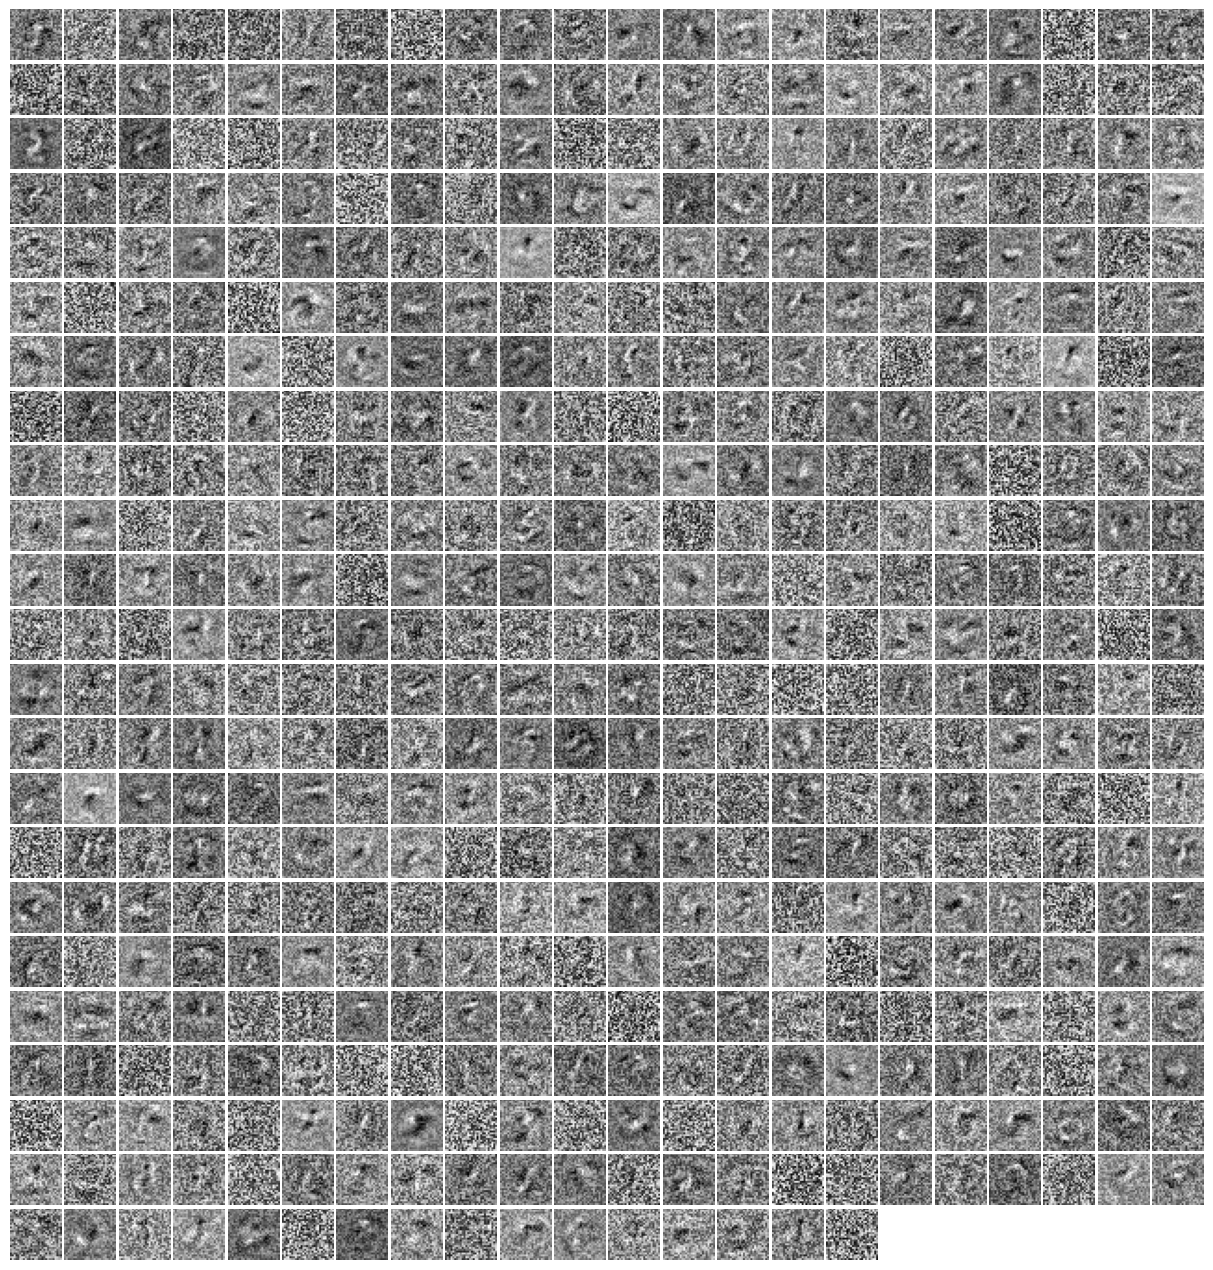

In [5]:
h1_weights = bp_network.module_dict['H1E_InputE'].weight.detach()
pt.plot_hidden_weights(h1_weights)

In [8]:
H1E_rf = bp_network.module_dict['H1E_InputE'].weight.detach()

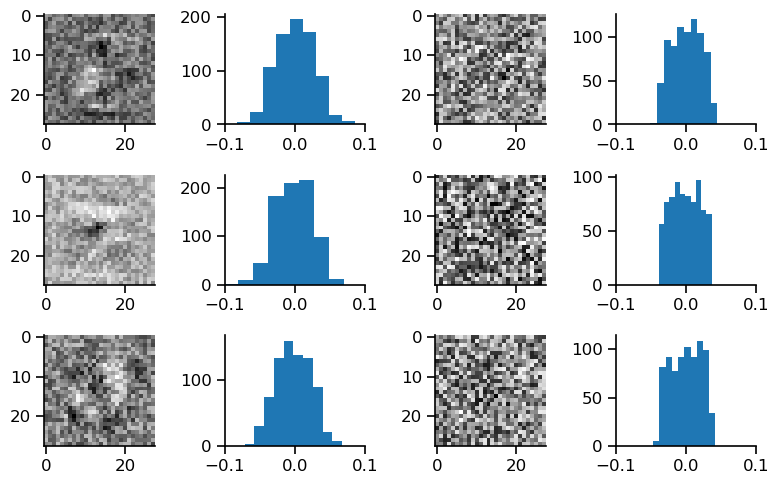

In [72]:
fig,ax = plt.subplots(3,4,figsize=(8,5))

unit = 18
ax[0,0].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[0,1].hist(H1E_rf[unit])
ax[0,1].set_xlim([-0.1,0.1])

unit = 87
ax[1,0].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[1,1].hist(H1E_rf[unit])
ax[1,1].set_xlim([-0.1,0.1])

unit = 1
ax[0,2].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[0,3].hist(H1E_rf[unit])
ax[0,3].set_xlim([-0.1,0.1])

unit = 19
ax[1,2].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[1,3].hist(H1E_rf[unit])
ax[1,3].set_xlim([-0.1,0.1])


unit = 300
ax[2,0].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[2,1].hist(H1E_rf[unit])
ax[2,1].set_xlim([-0.1,0.1])

unit = 200
ax[2,2].imshow(H1E_rf[unit].view(28,28),cmap='gray')
ax[2,3].hist(H1E_rf[unit])
ax[2,3].set_xlim([-0.1,0.1])


fig.tight_layout()
plt.show()

In [71]:
fields = ut.compute_receptive_fields(bp_network.H1.E, test_dataloader)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [88]:
fields.shape

torch.Size([500, 784])

In [113]:
for i,unit in enumerate(fields):
    fields[i] = (unit-torch.min(unit)) / (torch.max(unit) - torch.min(unit)) - 0.5

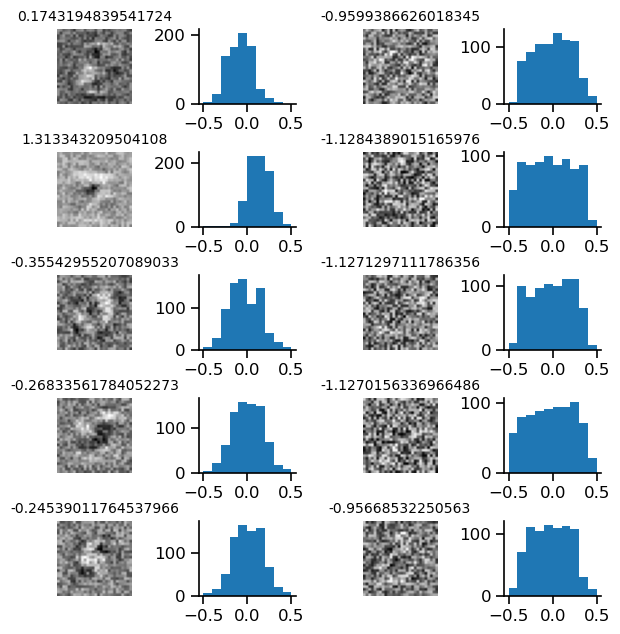

In [115]:
from scipy.stats import kurtosis

fig, ax = plt.subplots(5, 4, figsize=(6, 6.5))

units = [18,87,300,304,305]
for i, unit in enumerate(units):
    row = i
    col = 0
    ax[row, col].imshow(fields[unit].view(28, 28), cmap='gray')
    ax[row, col].axis('off')
    ax[row, col+1].hist(fields[unit])
    ax[row, col].set_title(kurtosis(fields[unit], fisher=False)-3,fontsize=10)

units = [1,19,200,499,204]
for i, unit in enumerate(units):
    row = i
    col = 2
    ax[row, col].imshow(fields[unit].view(28, 28), cmap='gray')
    ax[row, col].axis('off')
    ax[row, col+1].hist(fields[unit])
    ax[row, col].set_title(kurtosis(fields[unit], fisher=False)-3,fontsize=10)


fig.tight_layout()
plt.show()

# Backprop Dale network

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Batch accuracy = 90.20999908447266%


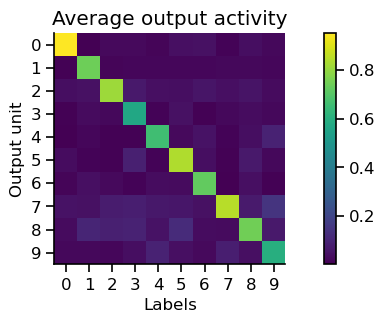

<Figure size 1000x300 with 0 Axes>

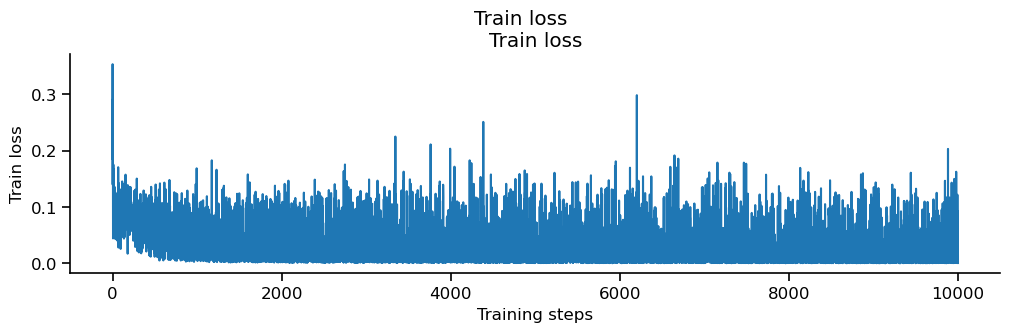

In [7]:
# Create network
network_config = ut.read_from_yaml('../optimize/data/20221219_EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train_and_validate(train_sub_dataloader, 
                              test_dataloader, 
                              epochs=epochs,
                              val_interval=(0,-1,100),
                              store_history=True, 
                              store_weights=False, 
                              status_bar=True)

pt.plot_batch_accuracy(bpDale_network, test_dataloader)
plt.figure()
pt.plot_train_loss_history(bpDale_network)
plt.title('Train loss')
plt.show()